### Bitcoin data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def get_bitcoin_data(filename: str) -> pd.DataFrame:
    """
    Reads the bitcoin csv data into a pandas dataframe.
    
    :param filename: bitcoin csv file name
    :return: df: bitcoin data as a pandas dataframe
    """
    
    df = pd.read_csv(filename)
    
    # converting 'Date' column to pd.datetime format to perform calculations
    df['Date'] = pd.to_datetime(df['Date'])
    
    return df

In [4]:
bitcoin_df = get_bitcoin_data('bitcoin_historical_data.csv')

### Law data

In [5]:
import pytz

In [6]:
def get_US_law_data(filename: str) -> pd.DataFrame:
    """
    This function reads the US Law data csv file into a pandas dataframe.
    
    :param filename: name of file with US Law data
    :return: dataframe containing US Law data
    """
    
    df = pd.read_csv(filename)
    
    df['Date of Introduction'] = pd.to_datetime(df['Date of Introduction'])
    df['Latest Action Date'] = pd.to_datetime(df['Latest Action Date'])
    
    # Making law data timezone aware to EST, since bitcoin data is timezone-aware
    df['Date of Introduction'] = df['Date of Introduction'].dt.tz_localize(None)
    est_tz = pytz.timezone('US/Eastern')
    df['Date of Introduction'] = df['Date of Introduction'].dt.tz_localize(None)
    
    return df

In [7]:
law_df1 = get_US_law_data('US_types.csv')

### SP500 data
After sp500 data is cleaned, merge it with bitcoin data.

In [8]:
def clean_and_fill_missing_dates(input_path: str) -> pd.DataFrame:
    # Load the data with minimal columns (adjust as per your dataset)
    data = pd.read_csv(input_path,encoding='utf-8', usecols=['Date', 'Adj Close', 'Close'])
    
    # Convert 'Date' column to datetime and drop invalid rows
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data = data.dropna(subset=['Date']).sort_values('Date')

    # Check the range of dates and create a complete range
    full_date_range = pd.date_range(start=data['Date'].min(), end=data['Date'].max())
    
    # Reindex to fill missing dates
    data = data.set_index('Date').reindex(full_date_range, method='ffill').reset_index()
    data.rename(columns={'index': 'Date'}, inplace=True)
    
    return data

In [9]:
# Clean and prepare S&P 500 data
sp500_df = clean_and_fill_missing_dates('sp500_data.csv')

bitcoin_df['Date'] = bitcoin_df['Date'].dt.tz_localize(None)
sp500_df['Date'] = sp500_df['Date'].dt.tz_localize(None)
start_date = max(bitcoin_df['Date'].min(), sp500_df['Date'].min())
end_date = min(bitcoin_df['Date'].max(), sp500_df['Date'].max())

# Find common dates
bitcoin_df = bitcoin_df[(bitcoin_df['Date'] >= start_date) & (bitcoin_df['Date'] <= end_date)]
sp500_df = sp500_df[(sp500_df['Date'] >= start_date) & (sp500_df['Date'] <= end_date)]
bitcoin_dates = set(bitcoin_df['Date'])
sp500_dates = set(sp500_df['Date'])
common_dates = bitcoin_dates.intersection(sp500_dates)

# Filter datasets to common dates
bitcoin_filtered = bitcoin_df[bitcoin_df['Date'].isin(common_dates)].sort_values('Date').reset_index(drop=True)
sp500_filtered = sp500_df[sp500_df['Date'].isin(common_dates)].sort_values('Date').reset_index(drop=True)

# Merge datasets
merged_data = pd.DataFrame({
    'Date': bitcoin_filtered['Date'],
    'Bitcoin_Close': bitcoin_filtered['Close'],
    'SP500_Close': sp500_filtered['Adj Close']
})

### Trends Analysis (Seasonal Analysis)

This part use the residuals between biticoin price and SP500 after OLS regressions, in order to get rid of the effect of systematic risks.

Y = a + b*X + resid, where Y is the return of SP500, and X is the return of bitcoin.

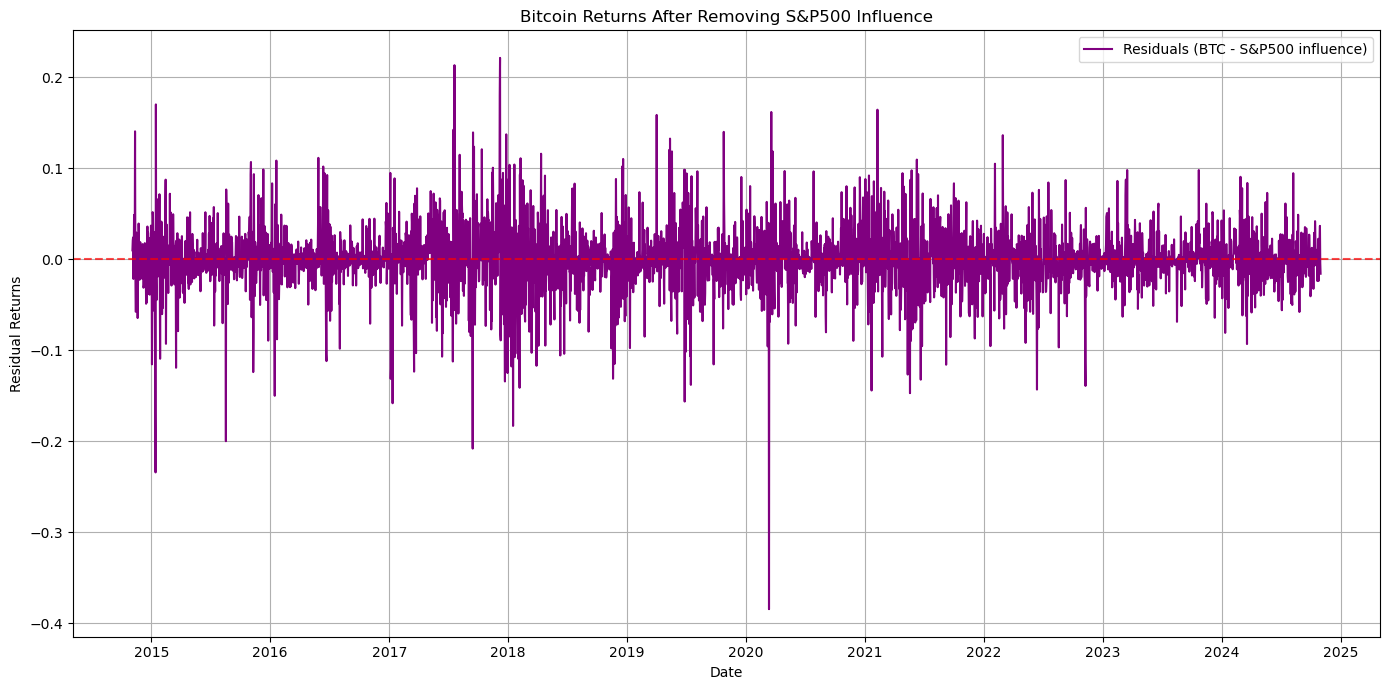

In [10]:
import numpy as np
import statsmodels.api as sm

merged_data['BTC_returns'] = np.log(merged_data['Bitcoin_Close'] / merged_data['Bitcoin_Close'].shift(1))
merged_data['SP500_returns'] = np.log(merged_data['SP500_Close'] / merged_data['SP500_Close'].shift(1))

# drop the first date since it's the first date
merged_data = merged_data.dropna()

X = merged_data['SP500_returns']
y = merged_data['BTC_returns']
X = sm.add_constant(X)  

# OLS regression
model = sm.OLS(y, X).fit()

# add it to merged_data
merged_data['BTC_residuals'] = model.resid

# plot it
plt.figure(figsize=(14, 7))
plt.plot(merged_data['Date'], merged_data['BTC_residuals'], label='Residuals (BTC - S&P500 influence)', color='purple')
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.title('Bitcoin Returns After Removing S&P500 Influence')
plt.xlabel('Date')
plt.ylabel('Residual Returns')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [11]:
merged_data

,Date,Bitcoin_Close,SP500_Close,BTC_returns,SP500_returns,BTC_residuals
1,2014-11-04,330.492004,2012.099976,0.008930,-0.002834,0.010007
2,2014-11-05,339.485992,2023.569946,0.026850,0.005684,0.020969
3,2014-11-06,349.290009,2031.209961,0.028470,0.003768,0.024153
4,2014-11-07,342.415009,2031.920044,-0.019879,0.000350,-0.021403
5,2014-11-08,345.488007,2031.920044,0.008934,0.000000,0.007696
...,...,...,...,...,...,...
3646,2024-10-27,67929.296875,5808.120117,0.013555,0.000000,0.012318
3647,2024-10-28,69907.757812,5823.520020,0.028709,0.002648,0.025308
3648,2024-10-29,72720.492188,5832.919922,0.039447,0.001613,0.036891
3649,2024-10-30,72339.539062,5813.669922,-0.005252,-0.003306,-0.003790


In [14]:
import matplotlib.dates as mdates
merged_data['Date'] = merged_data['Date'].dt.tz_localize(None)
merged_data['Volume'] = None

date_to_volume = bitcoin_df.set_index('Date')['Volume'].to_dict()

# Use map to update the Volume column in merged_data
merged_data['Volume'] = merged_data['Date'].map(date_to_volume)

# Normalize the Volume column
merged_data['Normalized_Volume'] = merged_data['Volume'] / merged_data['Volume'].max()

In [17]:
# Loop through each year from 2018 to 2024 and create a plot for each quarter
avg_t_list = []

for year in range(2018, 2025):
    for quarter in range(1, 5):
        # Define the start and end date for the current quarter
        start_date = pd.to_datetime(f'{year}-{(quarter-1)*3+1:02d}-01')
        end_date = pd.to_datetime(f'{year}-{quarter*3:02d}-01') + pd.DateOffset(months=1) - pd.Timedelta(days=1)

        # Convert start_date and end_date to naive datetime
        start_date = start_date.tz_localize(None)
        end_date = end_date.tz_localize(None)

        # Filter merged_data for the current quarter
        quarter_data = merged_data[(merged_data['Date'] >= start_date) & (merged_data['Date'] <= end_date)]

        # Filter event dates for the current quarter
        event_dates_quarter = law_df1[(law_df1['Date of Introduction'] >= start_date) & 
                                      (law_df1['Date of Introduction'] <= end_date)]['Date of Introduction'].tolist()
        
#         print(len(event_dates_quarter))
        
        if len(event_dates_quarter)== 0:
            continue
            
        sum_residuals = 0
        sum_volume = 0
        for event_date in event_dates_quarter:
            # Mark the 7-day event window
            event_start_window = event_date
            event_end_window = event_date + pd.Timedelta(days=7)
            df_data = merged_data[(merged_data['Date'] >= event_start_window)&(merged_data['Date'] <= event_end_window)]
            avg_residuals = df_data['BTC_residuals'].mean()
            avg_volume = df_data['Normalized_Volume'].mean()

            sum_residuals += avg_residuals
            sum_volume += avg_volume

        avg_volume_t = sum_volume / len(event_dates_quarter)
        avg_t_list.append({'year': year, 'quarter': quarter, 'avg_residuals': avg_residuals, 'avg_normalized_volume': avg_volume_t})

In [18]:
avg_t_df = pd.DataFrame(avg_t_list)
avg_t_df.to_csv('avg_t.csv', index=False)

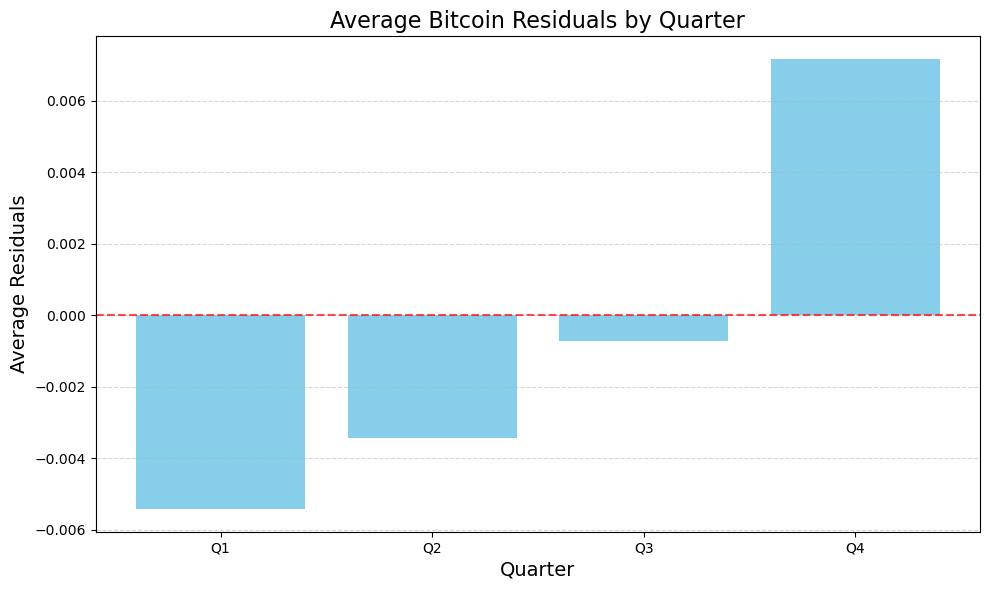

In [19]:
avg_t_new = pd.read_csv('avg_t.csv')

avg_t_new['quarter_label'] = 'Q' + avg_t_new['quarter'].astype(str)

quarterly_mean= avg_t_new.groupby('quarter_label')['avg_residuals'].mean().reset_index()

# print(quarterly_mean)
plt.figure(figsize=(10, 6))
plt.bar(quarterly_mean['quarter_label'], quarterly_mean['avg_residuals'], color='skyblue')

# add titles and labels
plt.title('Average Bitcoin Residuals by Quarter', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Average Residuals', fontsize=14)

# add lines
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# show
plt.tight_layout()
plt.show()

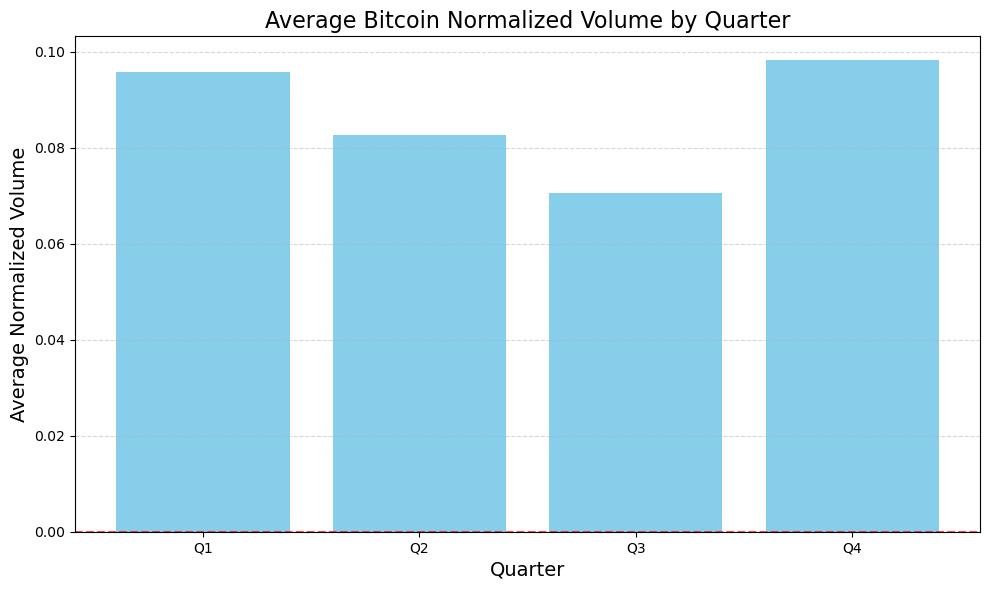

In [20]:
quarterly_mean2= avg_t_new.groupby('quarter_label')['avg_normalized_volume'].mean().reset_index()

# print(quarterly_mean)
plt.figure(figsize=(10, 6))
plt.bar(quarterly_mean2['quarter_label'], quarterly_mean2['avg_normalized_volume'], color='skyblue')

# add titles and labels
plt.title('Average Bitcoin Normalized Volume by Quarter', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Average Normalized Volume', fontsize=14)

# add lines
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# show
plt.tight_layout()
plt.show()

In [21]:
merged_data.to_csv('merged_data_new.csv', index=False)

### Type Analysis

This part will use the original price change percentage and average votatility to analyze.

In [22]:
merged_data_new = pd.read_csv('merged_data_new.csv')
merged_data_new['Date'] = pd.to_datetime(merged_data_new['Date'], errors='coerce')
# print(merged_data_new['Date'].dtype)

# Add a 'Quarter' column to the merged data for grouping
merged_data_new['Year'] = merged_data_new['Date'].dt.year
merged_data_new['Quarter'] = merged_data_new['Date'].dt.to_period('Q')

In [23]:
merged_data_new

,Date,Bitcoin_Close,SP500_Close,BTC_returns,SP500_returns,BTC_residuals,Volume,Normalized_Volume,Year,Quarter
0,2014-11-04,330.492004,2012.099976,0.008930,-0.002834,0.010007,15655500,0.000045,2014,2014Q4
1,2014-11-05,339.485992,2023.569946,0.026850,0.005684,0.020969,19817200,0.000056,2014,2014Q4
2,2014-11-06,349.290009,2031.209961,0.028470,0.003768,0.024153,18797000,0.000054,2014,2014Q4
3,2014-11-07,342.415009,2031.920044,-0.019879,0.000350,-0.021403,16834200,0.000048,2014,2014Q4
4,2014-11-08,345.488007,2031.920044,0.008934,0.000000,0.007696,8535470,0.000024,2014,2014Q4
...,...,...,...,...,...,...,...,...,...,...
3645,2024-10-27,67929.296875,5808.120117,0.013555,0.000000,0.012318,16721307878,0.047643,2024,2024Q4
3646,2024-10-28,69907.757812,5823.520020,0.028709,0.002648,0.025308,38799856657,0.110551,2024,2024Q4
3647,2024-10-29,72720.492188,5832.919922,0.039447,0.001613,0.036891,58541874402,0.166801,2024,2024Q4
3648,2024-10-30,72339.539062,5813.669922,-0.005252,-0.003306,-0.003790,40646637831,0.115813,2024,2024Q4


In [24]:
import seaborn as sns

def calculate_volatility_and_return_change(row, column_name):
    # Convert 'Date of Introduction' to Timestamp
    introduction_date = pd.to_datetime(row['Date of Introduction'])
    type1 = row[column_name]

    # Define date ranges using pd.Timestamp for efficiency
    before_start = introduction_date - pd.Timedelta(days=14)
    before_end = introduction_date - pd.Timedelta(days=1)
    after_start = introduction_date + pd.Timedelta(days=1)
    after_end = introduction_date + pd.Timedelta(days=14)

    # Filter data using query for concise filtering
    before_data = merged_data_new.query(f"Date >= '{before_start}' and Date <= '{before_end}'")
    after_data = merged_data_new.query(f"Date >= '{after_start}' and Date <= '{after_end}'")

    # Calculate volatility
    before_volatility = before_data['BTC_returns'].pct_change().std() 
    after_volatility = after_data['BTC_returns'].pct_change().std()

    # Calculate mean daily returns
    before_mean_return = before_data['BTC_returns'].mean()
    after_mean_return = after_data['BTC_returns'].mean()

    # Calculate change in mean daily returns
    return_change = after_mean_return - before_mean_return

    return pd.Series({
        'Type1': type1,
        'Law Introduction Date': introduction_date,
        'Before Volatility': before_volatility,
        'After Volatility': after_volatility,
        'Before Mean Return': before_mean_return,
        'After Mean Return': after_mean_return,
        'Return Change': return_change
    })

In [25]:
def plot_grouped_bar(data, title="Average Return Change by Event Type", ylabel="Average Return Change", xlabel="Event Type", color="skyblue", figsize=(10, 6)):
    """
    Plots a grouped bar chart for a given Series.

    Parameters:
        data (pd.Series): Data to plot, where the index represents categories and values represent the metric.
        title (str): Title of the plot.
        ylabel (str): Label for the y-axis.
        xlabel (str): Label for the x-axis.
        color (str): Color of the bars.
        figsize (tuple): Size of the figure.

    Returns:
        None: Displays the plot.
    """
    # Create the figure
    plt.figure(figsize=figsize)
    
    # Plot the bar chart
    data.plot(kind='bar', color=color, alpha=0.8)
    
    # Add labels, title, and reference line
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.axhline(0, color='red', linestyle='--', alpha=0.7)  # Reference line at 0
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

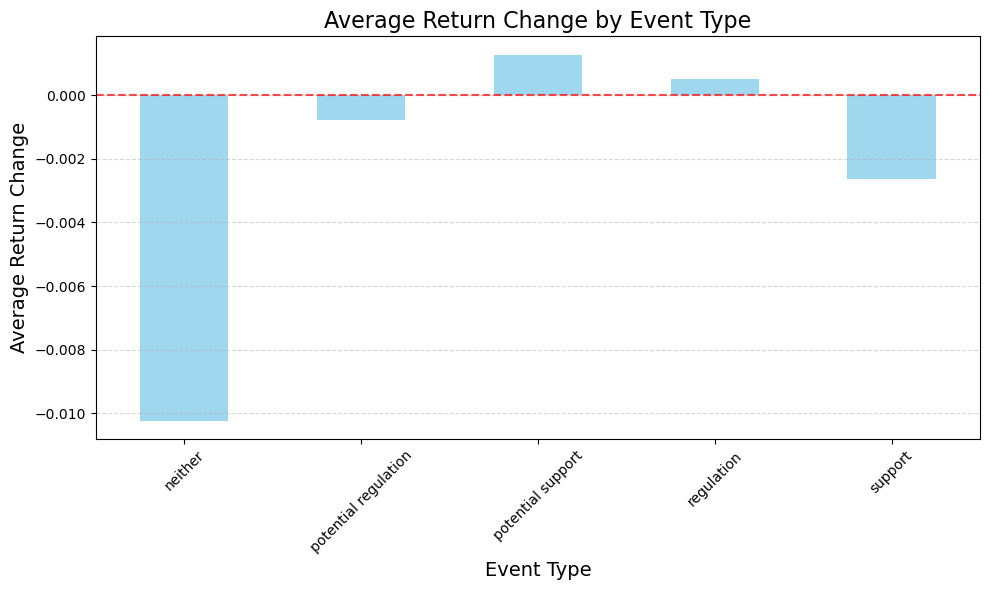

In [26]:
grouped_results = law_df1.apply(calculate_volatility_and_return_change, axis=1, column_name='Type1')
grouped_by_type = grouped_results.groupby('Type1')['Return Change'].mean()
plot_grouped_bar(
    data=grouped_by_type,  
    title="Average Return Change by Event Type",  
    ylabel="Average Return Change",  
    xlabel="Event Type",  
    color="skyblue"  
)

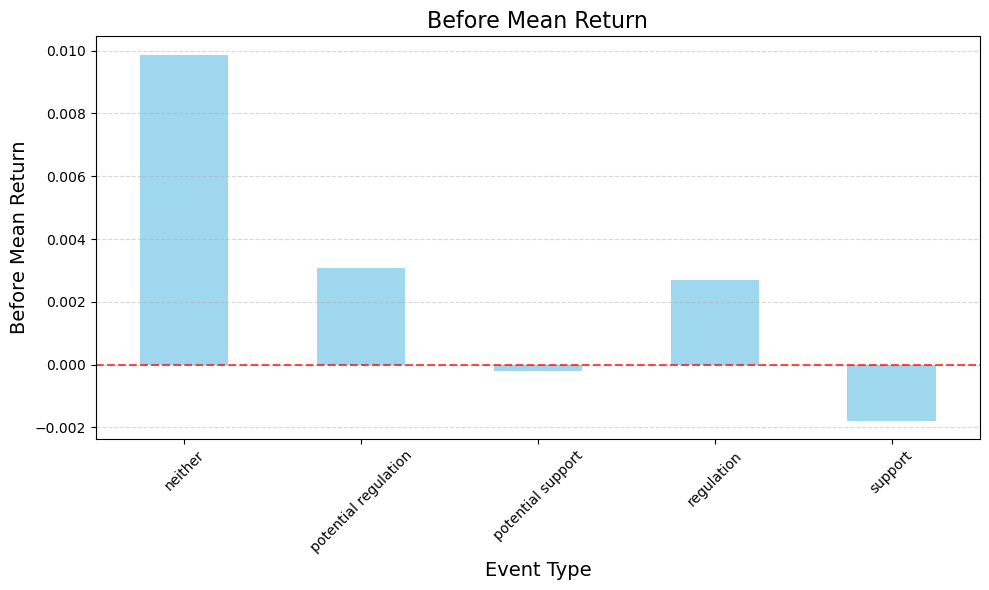

In [27]:
grouped_by_type2 = grouped_results.groupby('Type1')['Before Mean Return'].mean()
plot_grouped_bar(
    data=grouped_by_type2,  
    title="Before Mean Return",  
    ylabel="Before Mean Return",  
    xlabel="Event Type",  
    color="skyblue"  
)

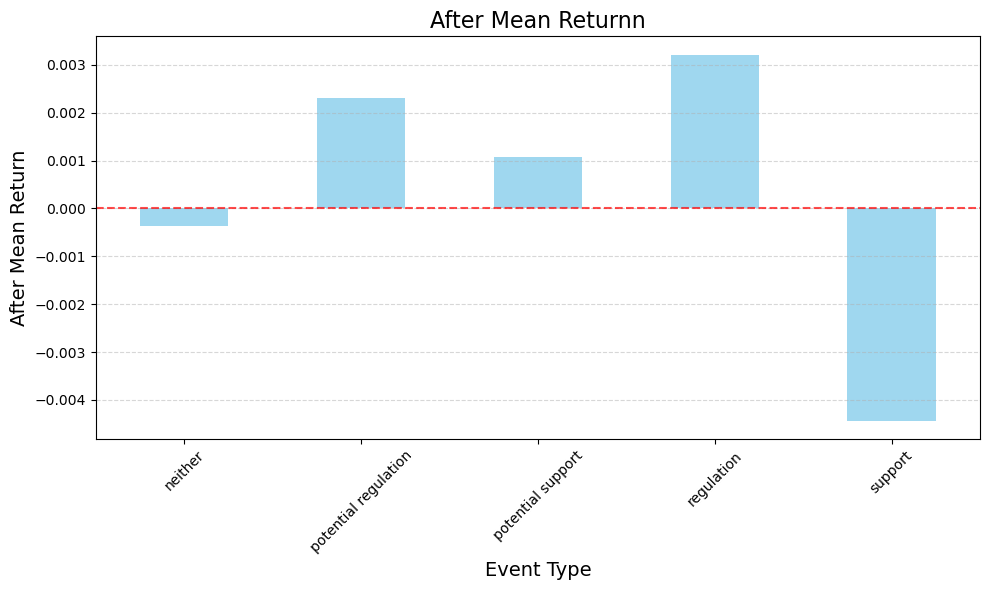

In [28]:
grouped_by_type3 = grouped_results.groupby('Type1')['After Mean Return'].mean()
plot_grouped_bar(
    data=grouped_by_type3,  
    title="After Mean Return",  
    ylabel="After Mean Return",  
    xlabel="Event Type",  
    color="skyblue"  
)

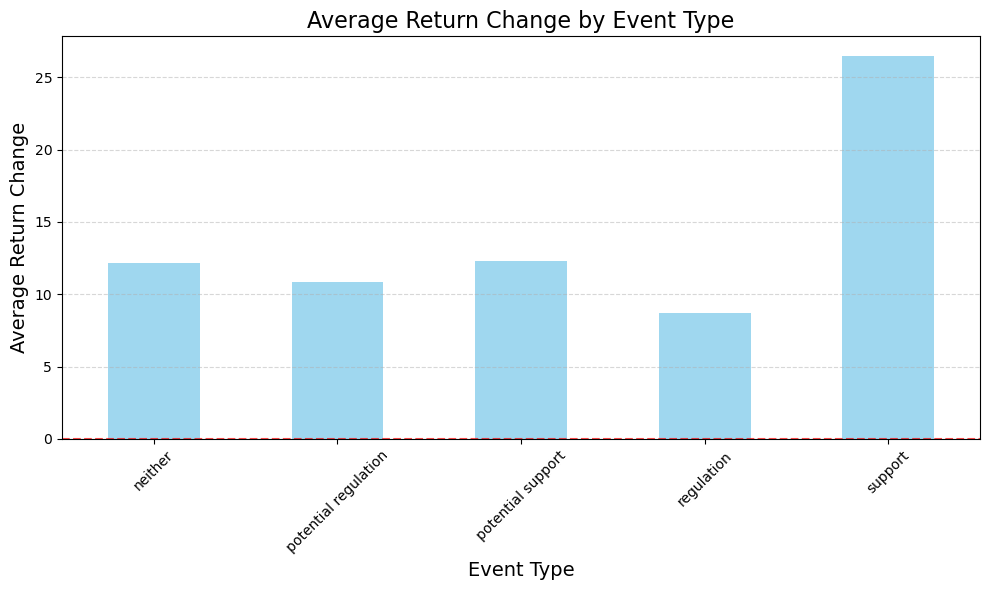

In [29]:
grouped_by_type4 = grouped_results.groupby('Type1')['Before Volatility'].mean()
plot_grouped_bar(
    data=grouped_by_type4,  
    title="Average Return Change by Event Type",  
    ylabel="Average Return Change",  
    xlabel="Event Type",  
    color="skyblue"  
)

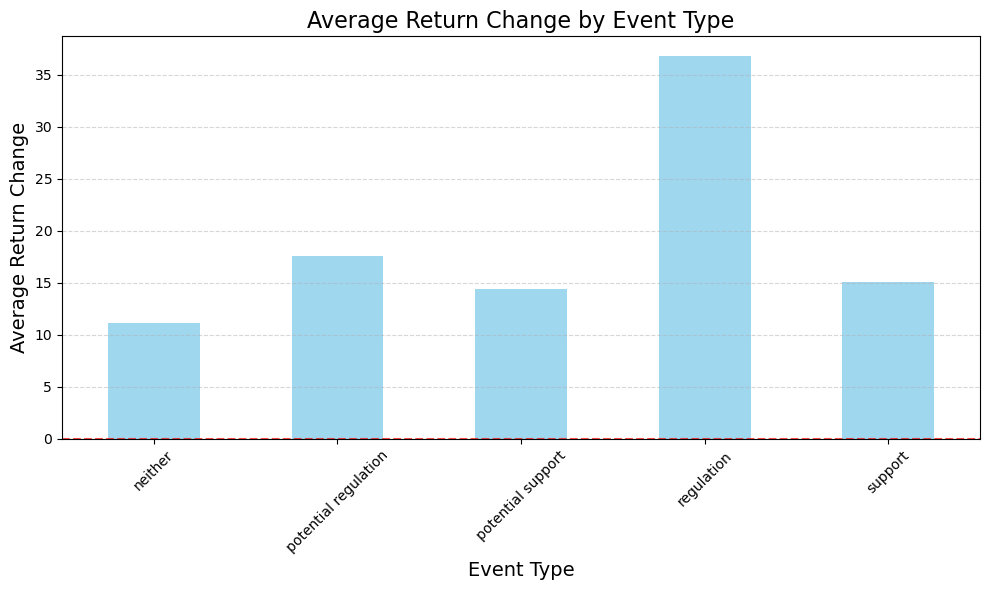

In [30]:
grouped_by_type5 = grouped_results.groupby('Type1')['After Volatility'].mean()
plot_grouped_bar(
    data=grouped_by_type5,  
    title="Average Return Change by Event Type",  
    ylabel="Average Return Change",  
    xlabel="Event Type",  
    color="skyblue" 
)